# Optimal Control Model for Experiment 1 - 1D lateral collaborative reaching task


In [1]:
import modelparams_exp1 as model_params
import models_exp1 as models
import numpy as np
import copy
import matplotlib.pyplot as plt
import sim_animator
from matplotlib.patches import Patch
import importlib
import scipy.linalg as linalg
import plot_parameters as plot_params
from scipy import signal as sig
import scipy.stats as stats
import saveload_workspace

# Defining Functions

In [18]:
# Running simulation for a single iLQR - simulating a single person performing the task with full feedback of states
def run_simulation_1iLQR(model_params, pert_type, RUNS):
    h = model_params.h # time step in s
    N = model_params.N # total number of time steps

    target_x, target_y = model_params.target_coordinates

    # model parameters
    params = model_params.params.copy()

    params['r'] = condition_params['F']['r']
    params['k'] = condition_params['F']['k']

    process_noise = model_params.process_noise
    hand_x_init = model_params.hand_x_init # hand initial x coordinates

    # initial system state
    x0 = np.zeros(24) 
    x0[[2, 4, 12, 14, 22, 23]] = [hand_x_init[0], hand_x_init[0], hand_x_init[1], hand_x_init[1], target_x, target_y]
    x0[[0, 1]] = (x0[[4, 5]] + x0[[14, 15]]) / 2

    M = models.Full_Model(X_eq=x0, params=params)
    u_nominal = np.zeros((4, N)) + 0.01 * np.array([0, 0.8, 0, 0.8]).reshape(4, 1) + np.random.normal(0, params['sig_u'], size=(4, N))
    x_nominal = M.generate_forwarddynamics(u_nominal, x0, M.nonlinear_sysode)

    x_target = np.zeros(len(x0)) 
    x_target[[0, 1, 22, 23]] = [target_x, target_y, target_x, target_y]
    
    X_runs = []
    trajectory_cost = []
    for run in range(RUNS):
        if RUNS % RUNS / 10 == 0:
            print(f'Running sim number {run}/{RUNS - 1}', end='\r')
        
        M.__init__(X_eq=x0, params=params)

        u = copy.copy(u_nominal)
        x = copy.copy(x_nominal)
        for iter_num in range(1):
            M.compute_controlfeedbackgains(x, u, x_target)
        
            # simulate the system and find optimal control
            u_new = np.zeros_like(u)
            u_del = np.zeros_like(u)
            x_new = np.zeros_like(x)
            x_new[:, 0] = x[:, 0].copy()
            x_del_est = np.zeros_like(x)
            x_del_est[:, 0] = x[:, 0] - x0
            
            x_new_aug = np.zeros((M.A_ldd.shape[0], N + 1))
            x_new_aug[:, 0] = np.tile(x0, params['visual delay'] + 1)
            
            x_est = copy.copy(x_new_aug)

            # running each simulation
            perturb_step = 0
            for step in range(N):       
                u_del[:, step] = -M.K[step, :, :] @ x_del_est[:, step] - M.Kv[step, :, :] @ M.v[step + 1, :] - M.Ku[step, :, :] @ u[:, step]
                
                u_new[:, step] = u_del[:, step] + u[:, step]

                x_new[:, step + 1] = x_new[:, step] +\
                    M.rk4_ode(x_new[:, step], u_new[:, step], M.nonlinear_sysode) +\
                    np.random.normal(0, process_noise)

                if x_new[0, step] > model_params.perturb_location:
                    if pert_type == 'M':
                        perturb_step += 1 
                        x_new[[3, 6, 13, 16], step + 1] += model_params.force_perturbation(perturb_step) / M.mh

                # augmenting the new state into the delayed states vector
                x_new_aug[:, step + 1] = M.augment_newstate(x_new[:, step + 1], x_new_aug[:, step])

                # estimate new state using measurements, previous state estimate, and control efference copy
                x_est[:, step + 1] = M.estimate_state(x_new_aug[:, step + 1], x_est[:, step], u_new[:, step])

                x_del_est[:, step + 1] = x_est[:M.A_ld.shape[0], step + 1] - x[:, step + 1]
                
            # model_params.plot_trajectory(X=x_new)

            # creating nominal trajectories for the next iteration
            u = copy.copy(u_new)
            x = copy.copy(x_est[:M.A_ld.shape[0], :])

        trajectory_cost.append(model_params.compute_trajectory_cost(params, M, x, u, x_target))

        X_runs.append(x_new[[0, 1, 4, 5, 14, 15, 2, 12], :])

    print(f'Avg Trajectory Cost = {np.mean(trajectory_cost)}')

    return X_runs

# Running simulation with two iLQR's - simulating two people performing the task with different modes of feedback
def run_simulation_2iLQR(fback_type, pert_type, model_params, RUNS):
    h = model_params.h # time step in s
    N = model_params.N # total number of time steps

    target_x, target_y = model_params.target_coordinates

    # model parameters
    # model parameters
    params = model_params.params.copy()

    # Set params specific to the experimental condition
    params['r'] = condition_params[fback_type]['r']
    params['k'] = condition_params[fback_type]['k']

    process_noise = model_params.process_noise
    hand_x_init = model_params.hand_x_init # hand initial x coordinates

    # initial system state
    x0 = np.zeros(24) 
    x0[[2, 4, 12, 14, 22, 23]] = [hand_x_init[0], hand_x_init[0], hand_x_init[1], hand_x_init[1], target_x, target_y]
    x0[[0, 1]] = (x0[[4, 5]] + x0[[14, 15]]) / 2

    M = models.Full_Model(X_eq=x0, params=params)
    L_H = models.LH_Model(fback_type=fback_type, X_eq=x0, params=params)
    R_H = models.RH_Model(fback_type=fback_type, X_eq=x0, params=params)
    
    u_nominal_L = 0.01 * np.array([0.0, 0.8]).reshape(L_H.control_len, 1) + np.random.normal(0, params['sig_u'], size=(2, N))
    u_nominal_R = 0.01 * np.array([0.0, 0.8]).reshape(L_H.control_len, 1) + np.random.normal(0, params['sig_u'], size=(2, N))

    u_nominal = np.concatenate((u_nominal_L, u_nominal_R), axis = 0)
    x_nominal = M.generate_forwarddynamics(u_nominal, x0, M.nonlinear_sysode)

    x_target = np.zeros(len(x0)) 
    x_target[[0, 1, 22, 23]] = [target_x, target_y, target_x, target_y]

    # selecting state indexes for L and R hand from the full state vector
    x_L_idxs = np.concatenate((np.arange(18), [22, 23])) 
    x_R_idxs = np.concatenate((np.arange(8), np.arange(12, 24))) 
    for obs_count in range(params['visual delay']):
        x_L_idxs = np.concatenate((x_L_idxs, x_L_idxs[-L_H.state_len:] + M.A_ld.shape[0]))
        x_R_idxs = np.concatenate((x_R_idxs, x_R_idxs[-R_H.state_len:] + M.A_ld.shape[0]))
    
    L_H.__init__(fback_type=fback_type, X_eq=x0, params=params)
    R_H.__init__(fback_type=fback_type, X_eq=x0, params=params)

    # NOTE: move these into the iteration loop if using more than one iteration. Have these outside to save simulation time if only using one iteration.
    L_H.compute_controlfeedbackgains(x_nominal[x_L_idxs[:L_H.state_len], :], u_nominal_L, x_target[x_L_idxs[:L_H.state_len]])
    R_H.compute_controlfeedbackgains(x_nominal[x_R_idxs[:R_H.state_len], :], u_nominal_R, x_target[x_R_idxs[:R_H.state_len]])
    
    X_runs = []
    trajectory_cost = []
    for run in range(RUNS):
        print(f'Running batch {batch}/{BATCHES - 1}, Feedback type {fback_type}, Sim no {run}/{RUNS - 1}', end='\r')
        
        L_H.__init__(fback_type=fback_type, X_eq=x0, params=params)
        R_H.__init__(fback_type=fback_type, X_eq=x0, params=params)
            
        u = copy.copy(u_nominal)
        u_L = copy.copy(u_nominal_L)
        u_R = copy.copy(u_nominal_R)
        x = copy.copy(x_nominal)
        x_L = x_nominal[x_L_idxs[:L_H.state_len], :]
        x_R = x_nominal[x_R_idxs[:R_H.state_len], :]
        for iter_num in range(1):
            # print(f'Running iteration number {iter_num}')
            
            # simulate the system and find optimal control  
            u_new = np.zeros_like(u)
            u_new_L = np.zeros_like(u_L)
            u_del_L = np.zeros_like(u_L)
            u_new_R = np.zeros_like(u_R)
            u_del_R = np.zeros_like(u_R)
            x_new = copy.copy(x)
            x_del_est_L = np.zeros_like(x_L)
            x_del_est_L[:, 0] = x_L[:, 0] - x0[x_L_idxs[:L_H.state_len]]
            x_del_est_R = np.zeros_like(x_R)
            x_del_est_R[:, 0] = x_R[:, 0] - x0[x_R_idxs[:R_H.state_len]]
            
            x_new_aug = np.zeros((M.A_ldd.shape[0], N + 1))
            x_new_aug[:, 0] = np.tile(x0, params['visual delay'] + 1)
            
            x_est_L = copy.copy(x_new_aug[x_L_idxs, :])
            x_est_R = copy.copy(x_new_aug[x_R_idxs, :])

            # Running each simulation
            perturb_step = 0
            for step in range(N):       
                u_del_L[:, step] = -L_H.K[step, :, :] @ x_del_est_L[:, step] - L_H.Kv[step, :, :] @ L_H.v[step + 1, :] - L_H.Ku[step, :, :] @ u_L[:, step]
                u_del_R[:, step] = -R_H.K[step, :, :] @ x_del_est_R[:, step] - R_H.Kv[step, :, :] @ R_H.v[step + 1, :] - R_H.Ku[step, :, :] @ u_R[:, step]
                
                u_new_L[:, step] = u_del_L[:, step] + u_L[:, step]
                u_new_R[:, step] = u_del_R[:, step] + u_R[:, step]
                
                u_new[:, step] = np.concatenate((u_new_L[:, step], u_new_R[:, step]))
                        
                # propagate true state with calculated controls
                x_new[:, step + 1] = x_new[:, step] +\
                    M.rk4_ode(x_new[:, step], u_new[:, step], M.nonlinear_sysode) +\
                        np.random.normal(0, process_noise)

                # Apply perturbation
                if x_new[0, step] > model_params.perturb_location:
                    perturb_step += 1 
                    if pert_type == 'M':
                        x_new[[3, 6, 13, 16], step + 1] += model_params.force_perturbation(perturb_step) / M.mh

                x_new_aug[:, step + 1] = M.augment_newstate(x_new[:, step + 1], x_new_aug[:, step])
                
                # estimate new state using measurements, previous state estimate, and control efference copy
                x_est_L[:, step + 1] = L_H.estimate_state(x_new_aug[x_L_idxs, step + 1], x_est_L[:, step], u_new_L[:, step])
                x_est_R[:, step + 1] = R_H.estimate_state(x_new_aug[x_R_idxs, step + 1], x_est_R[:, step], u_new_R[:, step])
                
                x_del_est_L[:, step + 1] = x_est_L[:L_H.state_len, step + 1] - x_L[:, step + 1]
                x_del_est_R[:, step + 1] = x_est_R[:R_H.state_len, step + 1] - x_R[:, step + 1]
            
            # x_new = generate_forwarddynamics(h, u_new, x0, M.nonlinear_sysode)
            # model_params.plot_trajectory(X=x_new)

            u = copy.copy(u_new)
            u_L = copy.copy(u_new_L)
            u_R = copy.copy(u_new_R)
            x = copy.copy(x_new)
            x_L = copy.copy(x_est_L[:L_H.state_len, :])
            x_R = copy.copy(x_est_R[:R_H.state_len, :])

        # trajectory_cost.append(model_params.compute_trajectory_cost(params, M, x, u, x_target))

        X_runs.append(x_new[[0, 1, 4, 5, 14, 15, 2, 12], :])
    
    # print(f'Avg Trajectory Cost = {np.mean(trajectory_cost)}')
    print("                                                                        ", end='\r')

    return X_runs

# Plotting mean lateral coordinates of the midpoint from all runs within a batch
def plot_timetrajectories_meanruns(data, batch_no, data_type, max_time_sample, yticks, text_annotations, params):
    t = np.arange(0, max_time_sample) * model_params.h * 1000

    data_type_map = {'x': 0, 'y':1}

    fig, ax = plt.subplots(figsize=(14, 9))
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False,
                   left=True, right=False)
    ax.spines['left'].set_color(params.axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(params.axis_color)
    ax.spines['bottom'].set_linewidth(params.axis_linewidth)
    ax.spines['left'].set_linewidth(params.axis_linewidth)
    ax.xaxis.set_tick_params(width=params.axis_linewidth)
    ax.yaxis.set_tick_params(width=params.axis_linewidth)
    ax.tick_params(axis='both', colors=params.axis_color, labelsize=params.tick_fsize + 4)
    ax.set_ylim(-0.5, yticks[-1])
    ax.set_yticks(yticks)
    ax.set_xlim((0, t[-1]+11))
    ax.set_xticks(np.arange(t[0], t[-1]+11, 1000))

    if data_type == 'x':
        ax.set_ylabel('Midpoint Lateral\nPosition (cm)', fontsize=params.axis_fsize + 4,
                    color=params.axis_color, weight=params.font_weight)
    else:
        ax.set_ylabel('Midpoint Forward\nPosition (cm)', fontsize=params.axis_fsize + 4,
            color=params.axis_color, weight=params.font_weight)                
     
    ax.set_xlabel('Trial Time (ms)', fontsize=params.axis_fsize,
                color=params.axis_color, weight=params.font_weight)
    ax.axhline(y=15, color=params.annotation_color, linestyle='--', linewidth=params.axis_linewidth)

    for text in text_annotations:
        ax.annotate(text[0], xycoords='data', xy=(text[1][0], text[1][1]), fontweight=params.font_weight, 
                    color=params.annotation_color, fontsize=params.legend_fsize  + 4, ha='center')

    data_array = np.array(data[batch_no])
    for condition_idx, condition in enumerate(conditions):  
        condition_data = data_array[condition_idx] * 100

        x_mean = np.mean(condition_data[:, data_type_map[data_type], :max_time_sample], axis=0)
        x_std = np.std(condition_data[:, data_type_map[data_type], :max_time_sample], axis=0)

        ax.plot(t, x_mean, color=params.condition_colors[condition], linewidth=3, zorder=2)
        ax.fill_between(t, x_mean-x_std, x_mean+x_std,
                        color=params.condition_colors[condition], edgecolor=None, alpha=0.4)
    
    # custom_legend = [Patch(facecolor=params.condition_colors[condition], label=params.condition_names[condition]) for condition in conditions]
    # lg = ax.legend(handles=custom_legend, loc='upper center', ncol=2, prop={'weight': params.font_weight, 'size': params.legend_fsize + 2})

    # lg.get_frame().set_linewidth(0.0)
    # lg.get_frame().set_alpha(0.0)

    # for Condition_idx, Condition_legend in enumerate(lg.get_texts()):
    #     Condition_legend.set_color(custom_legend[Condition_idx].get_facecolor())
    
    plt.tight_layout()
    
    return fig

# Plotting mean lateral coordinates of the midpoint from all batches
def plot_timetrajectories_meanbatches(data, data_type, max_time_sample, yticks, text_annotations, params):
    t = np.arange(0, max_time_sample) * model_params.h * 1000

    data_type_map = {'x': 0, 'y':1}

    fig, ax = plt.subplots(figsize=(14, 9))
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False,
                   left=True, right=False)
    ax.spines['left'].set_color(params.axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(params.axis_color)
    ax.spines['bottom'].set_linewidth(params.axis_linewidth)
    ax.spines['left'].set_linewidth(params.axis_linewidth)
    ax.xaxis.set_tick_params(width=params.axis_linewidth)
    ax.yaxis.set_tick_params(width=params.axis_linewidth)
    ax.tick_params(axis='both', colors=params.axis_color, labelsize=params.tick_fsize + 4)
    ax.set_ylim(-0.5, yticks[-1])
    ax.set_yticks(yticks)
    ax.set_xlim((0, t[-1]+11))
    ax.set_xticks(np.arange(t[0], t[-1]+11, 1000))
    ax.set_xticklabels(np.arange(t[0], t[-1]+11, 1000) / 1000)

    if data_type == 'x':
        ax.set_ylabel('Midpoint Lateral\nPosition (cm)', fontsize=params.axis_fsize + 4,
                    color=params.axis_color, weight=params.font_weight)
    else:
        ax.set_ylabel('Midpoint Forward\nPosition (cm)', fontsize=params.axis_fsize + 4,
            color=params.axis_color, weight=params.font_weight)                
     
    ax.set_xlabel('Trial Time (s)', fontsize=params.axis_fsize,
                color=params.axis_color, weight=params.font_weight)
    ax.axhline(y=15, color=params.annotation_color, linestyle='--', linewidth=params.axis_linewidth)

    for text in text_annotations:
        ax.annotate(text[0], xycoords='data', xy=(text[1][0], text[1][1]), fontweight=params.font_weight, 
                    color=params.annotation_color, fontsize=params.legend_fsize  + 4, ha='center')

    data_array = np.array(data)
    for condition_idx, condition in enumerate(conditions):
        run_means = np.mean(data_array[:, condition_idx], axis=1) * 100
        
        x_mean = np.mean(run_means[:, data_type_map[data_type], :max_time_sample], axis=0)
        x_std = np.std(run_means[:, data_type_map[data_type], :max_time_sample], axis=0) / run_means.shape[0] ** 0.5

        ax.plot(t, x_mean, color=params.condition_colors[condition], linewidth=3, zorder=2)
        ax.fill_between(t, x_mean-x_std, x_mean+x_std,
                        color=params.condition_colors[condition], edgecolor=None, alpha=0.4)
    
    # custom_legend = [Patch(facecolor=params.condition_colors[condition], label=params.condition_names[condition]) for condition in conditions]
    # lg = ax.legend(handles=custom_legend, loc='upper center', ncol=2, prop={'weight': params.font_weight, 'size': params.legend_fsize + 2})

    # lg.get_frame().set_linewidth(0.0)
    # lg.get_frame().set_alpha(0.0)

    # for Condition_idx, Condition_legend in enumerate(lg.get_texts()):
    #     Condition_legend.set_color(custom_legend[Condition_idx].get_facecolor())
    
    plt.tight_layout()
    
    return fig

# Plotting lateral coordinates of the midpoint and hands from a single batch i.e. one dyad
def plot_cursorhand_timetrajectories(data, condition_idx, data_type, max_time_sample, yticks, text_annotations, params):
    t = np.arange(0, max_time_sample) * model_params.h * 1000

    data_type_map = {'x': 0, 'y':1}

    fig, ax = plt.subplots(figsize=(14, 9))
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False,
                   left=True, right=False)
    ax.spines['left'].set_color(params.axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(params.axis_color)
    ax.spines['bottom'].set_linewidth(params.axis_linewidth)
    ax.spines['left'].set_linewidth(params.axis_linewidth)
    ax.xaxis.set_tick_params(width=params.axis_linewidth)
    ax.yaxis.set_tick_params(width=params.axis_linewidth)
    ax.tick_params(axis='both', colors=params.axis_color, labelsize=params.tick_fsize + 6)
    ax.set_ylim(-11, yticks[-1])
    ax.set_yticks(yticks)
    ax.set_xlim((0, t[-1]+11))
    ax.set_xticks(np.arange(t[0], t[-1]+11, 1000))
    ax.set_xticklabels(np.arange(t[0], t[-1]+11, 1000) / 1000)

    if data_type == 'x':
        ax.set_ylabel('Lateral Midpoint\nPosition (cm)', fontsize=params.axis_fsize + 6,
                    color=params.axis_color, weight=params.font_weight)
        data_coordmap = {'m': 0, 'l': 2, 'r': 4}
    else:
        ax.set_ylabel('Forward Midpoint\nPosition (cm)', fontsize=params.axis_fsize + 6,
            color=params.axis_color, weight=params.font_weight)     
        data_coordmap = {'m': 1, 'l': 3, 'r': 5}           
     
    ax.set_xlabel('Time (s)', fontsize=params.axis_fsize + 6,
                color=params.axis_color, weight=params.font_weight)
    ax.axhline(y=15, color=params.annotation_color, linestyle='--', linewidth=params.axis_linewidth)

    for text in text_annotations:
        ax.annotate(text[0], xycoords='data', xy=(text[1][0], text[1][1]), fontweight=params.font_weight, 
                    color=params.annotation_color, fontsize=params.legend_fsize  + 6, ha='center')

    xdata = data[condition_idx]
    for run in range(len(xdata)):
        ax.plot(t, xdata[run][data_coordmap['m'], :max_time_sample] * 100, color=params.condition_colors[conditions[condition_idx]], linewidth=1, zorder=2)
        ax.plot(t, xdata[run][data_coordmap['l'], :max_time_sample] * 100, color=[0.3, 0.3, 0.3], linewidth=1)
        ax.plot(t, xdata[run][data_coordmap['r'], :max_time_sample] * 100, color=[0.3, 0.3, 0.3], linewidth=1)

    plt.tight_layout()

    return fig

# Calculating task-relevant and task-irrelevant variabilities using UCM   
def calculate_variabilities(X_runs):
    A = np.array([[0.5, 0.5, 0, 0], [0, 0, 0.5, 0.5]]) # [Cx, Cy]' = A @ [Xl, Xr, Yl, Yr]' state vector
    V = linalg.null_space(A) # null space vectors

    var_task = np.zeros(X_runs[0].shape[1])
    var_null = np.zeros_like(var_task)
    h_coord = np.zeros((4, len(X_runs)))
    for t_sample in range(X_runs[0].shape[1]):
        for run_no in range(len(X_runs)):
            h_coord[:2, run_no] = X_runs[run_no][[2, 4], t_sample] * 100

        # # Method 1: By using Moore-Penrose inverse
        # h_task = A.T @ np.linalg.inv(A @ A.T) @ A @ h_coord
        # h_null = (np.eye(4) - A.T @ np.linalg.inv(A @ A.T) @ A) @ h_coord
        # var_task[file_no, condition_idx] = np.sum(np.var(h_task, axis=1))
        # var_null[file_no, condition_idx] = np.sum(np.var(h_null, axis=1))

        # Method 2: By projecting the deviations onto null space
        h_coord_del = h_coord - np.mean(h_coord, axis=1).reshape(4, 1)

        h_null = (V[:, 0].T @ h_coord_del) * V[:, 0].reshape(4, 1) +\
                    (V[:, 1].T @ h_coord_del) * V[:, 1].reshape(4, 1)
        
        h_task = h_coord_del - h_null

        var_task[t_sample] = np.sum(h_task ** 2) / h_coord.shape[1]
        var_null[t_sample] = np.sum(h_null ** 2) / h_coord.shape[1]
    
    return var_task, var_null

# Plotting variabilities with time
def plot_variabilities(var, var_type, max_time_sample, yticks, legend_loc, params): 
    t = np.arange(0, max_time_sample) * model_params.h * 1000
    
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False,
                   left=True, right=False)
    ax.spines['left'].set_color(params.axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(params.axis_color)
    ax.spines['bottom'].set_linewidth(params.axis_linewidth)
    ax.spines['left'].set_linewidth(params.axis_linewidth)
    ax.xaxis.set_tick_params(width=params.axis_linewidth)
    ax.yaxis.set_tick_params(width=params.axis_linewidth)
    ax.tick_params(axis='both', colors=params.axis_color, labelsize=params.tick_fsize)
    ax.set_ylim(yticks[0] - 0.02 * yticks[-1], yticks[-1])
    ax.set_yticks(yticks)
    ax.set_xlim((0, t[-1]+11))
    ax.set_xticks(np.arange(t[0], t[-1]+11, 500))
    ax.set_xticklabels(np.arange(t[0], t[-1]+11, 500) / 1000)

    if var_type == 'Task':
        ax.set_ylabel(f'Task-Relevant\nMovement Variability ' + r'($\bf{cm^2}$)', fontsize=params.axis_fsize,
                    color=params.axis_color, weight=params.font_weight)
    else:
        ax.set_ylabel(f'Task-Irrelevant\nMovement Variability ' + r'($\bf{cm^2}$)', fontsize=params.axis_fsize,
                color=params.axis_color, weight=params.font_weight)                    
    ax.set_xlabel('Time (s)', fontsize=params.axis_fsize, color=params.axis_color, weight=params.font_weight)
    
    var_mean = np.nanmean(var, axis=0)
    var_stderr = np.nanstd(var, axis=0) / var.shape[0] ** 0.5
    for ftype_idx, ftype in enumerate(conditions):
        ax.plot(t, var_mean[ftype_idx, :max_time_sample], color=params.condition_colors[ftype], zorder=2, linewidth=3)
        ax.fill_between(t, var_mean[ftype_idx, :max_time_sample] + var_stderr[ftype_idx, :max_time_sample], 
                        var_mean[ftype_idx, :max_time_sample] - var_stderr[ftype_idx, :max_time_sample],
                        color=params.condition_colors[ftype], edgecolor=None, alpha=0.4)

    custom_legend = [Patch(facecolor=params.condition_colors[condition], label=params.condition_names[condition]) for condition in conditions]
    lg = ax.legend(handles=custom_legend, loc=legend_loc, ncol=1, prop={'weight': params.font_weight, 'size': params.legend_fsize})

    lg.get_frame().set_linewidth(0.0)
    lg.get_frame().set_alpha(0.0)

    for Condition_idx, Condition_legend in enumerate(lg.get_texts()):
        Condition_legend.set_color(custom_legend[Condition_idx].get_facecolor())
    
    plt.tight_layout()

    return fig

# Plotting summary of variabilities
def plot_variabilities_boxplot(var_data, var_type, step_window, yticks_boxplot, params):
    box_locations = np.arange(3)
    box_width = 0.5

    if len(var_data.shape) == 2:
        mean_var = np.mean(var_data, axis=1)[None, :]
    elif len(var_data.shape) == 3:
        mean_var = np.mean(var_data[:, :, step_window[0]: step_window[1]], axis=2)

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False,
                   left=True, right=False)
    ax.spines['left'].set_color(params.axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(params.axis_color)
    ax.spines['bottom'].set_linewidth(params.axis_linewidth)
    ax.spines['left'].set_linewidth(params.axis_linewidth)
    ax.xaxis.set_tick_params(width=params.axis_linewidth)
    ax.yaxis.set_tick_params(width=params.axis_linewidth)
    ax.tick_params(axis='both', colors=params.axis_color, labelsize=params.tick_fsize)
    ax.set_ylim(yticks_boxplot[0], yticks_boxplot[-1])
    ax.set_yticks(yticks_boxplot)
    ax.set_xlim((-box_width, box_locations[-1] + box_width))
    if var_type == 'Task':
        ax.set_ylabel(f'Task-Relevant\nMovement Variability ' + r'($\bf{cm^2}$)', fontsize=params.axis_fsize,
                    color=params.axis_color, weight=params.font_weight)
    else:
        ax.set_ylabel(f'Task-Irrelevant\nMovement Variability ' + r'($\bf{cm^2}$)', fontsize=params.axis_fsize,
                color=params.axis_color, weight=params.font_weight)   
    
    for col, condition in enumerate(conditions):
        box_plot = ax.boxplot(x=mean_var[:, col], positions=[box_locations[col]], widths=box_width, showfliers=False)
        for item in ['boxes', 'whiskers', 'medians', 'caps']:
            plt.setp(box_plot[item], color=params.condition_colors[condition], linewidth=params.boxplot_linewidth)
        
    # x_coords_points = np.zeros(mean_var.shape[:2])
    # for condition_idx in range(mean_var.shape[1]):
    #     x_coords_points[:, condition_idx] = np.array([box_locations[condition_idx] + np.random.uniform(-box_width / 3, box_width / 3)
    #                        for point in range(mean_var.shape[0])])
    #     ax.scatter(x_coords_points[:, condition_idx], mean_var[:, condition_idx], s=400, marker='o', facecolors=params.figure_theme_color,
    #      edgecolors=params.individual_data_color, linewidth=3, alpha=1.0)

    # for subj in range(mean_var.shape[0]):
    #     ax.plot(x_coords_points[subj, :], mean_var[subj, :], linewidth=3, color=params.individual_data_color, zorder=0)

    ax.set_xticklabels(box_locations, weight=params.font_weight)
    ax.set_xticks(box_locations)
    ax.set_xticklabels([plot_params.condition_names2[condition] for condition in conditions], fontsize=params.axis_fsize)
    for condition_idx, xtick in enumerate(ax.get_xticklabels()):
        xtick.set_color(params.condition_colors[conditions[condition_idx]])
    
    # dh = 0.05
    # dx = box_width / 10
    # if comparison == 'v':
    #     p_value_bar_xlocations = np.array([box_locations[0], box_locations[2], box_locations[0] + 0.5,
    #                             box_locations[0] + 0.5, box_locations[2] + 0.5,
    #                             box_locations[2] + 0.5, box_locations[1], box_locations[3]])
    #     p_value_bar_ylocations = np.array([0, 0, 0, pval_height, pval_height, pval_height/2, pval_height/2, pval_height/2]) + p_value_loc
    # else:
    #     p_value_bar_xlocations = np.array([box_locations[0], box_locations[1], box_locations[0] + 0.5,
    #                     box_locations[0] + 0.5, box_locations[2] + 0.5,
    #                     box_locations[2] + 0.5, box_locations[2], box_locations[3]])
    #     p_value_bar_ylocations = np.array([0, 0, 0, pval_height, pval_height, 0.0, 0.0, 0.0]) + p_value_loc
    
    # p_value_height = pval_height / 2
    # p_value_display = []
    # if p_value < 0.001:
    #     p_value_display.append('p < 0.001')
    # else:
    #     p_value_display.append('p = {:.3f}'.format(p_value))

    # ax.plot(p_value_bar_xlocations, p_value_bar_ylocations, color=params.annotation_color,
    #         linewidth=3)
    # ax.annotate(p_value_display[0], xycoords='data',
    #             xy=(box_locations[1] + 0.5, max(p_value_bar_ylocations) + p_value_height),
    #             va='center', ha='center', color=params.annotation_color, fontsize=params.pval_fsize, weight="bold")

    plt.tight_layout()

    return fig

# Quantifying movement smoothness using the log dimensionless jerk metric
def calculate_logdimjerk(X_runs):
    ldj = np.zeros(len(X_runs))
    for run_no in range(len(X_runs)):
        xy_coord = X_runs[run_no][[0, 1], :] * 100

        fs = 1 / 0.001
        f_c = 60
        b, a = sig.butter(6, f_c / fs / 2, 'low')
        # _xy_coord = sig.filtfilt(b, a, xy_coord)
        
        xy_vel = (-xy_coord[:, 3:-1] + 8 * xy_coord[:, 2:-2] - 8 * xy_coord[:, 1:-3] + xy_coord[:, 0:-4]) / 12 * fs
        xy_accel = (-xy_vel[:, 3:-1] + 8 * xy_vel[:, 2:-2] - 8 * xy_vel[:, 1:-3] + xy_vel[:, 0:-4]) / 12 * fs
        xy_jerk = (-xy_accel[:, 3:-1] + 8 * xy_accel[:, 2:-2] - 8 * xy_accel[:, 1:-3] + xy_accel[:, 0:-4]) / 12 * fs
        
        vel_net = (xy_vel[0, :] ** 2 + xy_vel[1, :] ** 2) ** 0.5
        jerk_net = (xy_jerk[0, :] ** 2 + xy_jerk[1, :] ** 2) ** 0.5

        dj = (len(jerk_net) / fs) ** 4  / np.max(vel_net ** 2) * np.sum(jerk_net ** 2 / fs) 
        ldj[run_no] = -np.log(dj)
    
    return ldj

# Plotting log dimensionless jerk
def plot_logdimjerk_boxplot(ldj, yticks_boxplot, arrow_props, params):
    box_locations = np.arange(ldj.shape[1])
    box_width = 0.5

    mean_ldj = np.mean(ldj, axis=2)

    fig, ax = plt.subplots(figsize=(14, 9))
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False,
                   left=True, right=False)
    ax.spines['left'].set_color(params.axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(params.axis_color)
    ax.spines['bottom'].set_linewidth(params.axis_linewidth)
    ax.spines['left'].set_linewidth(params.axis_linewidth)
    ax.xaxis.set_tick_params(width=params.axis_linewidth)
    ax.yaxis.set_tick_params(width=params.axis_linewidth)
    ax.tick_params(axis='both', colors=params.axis_color, labelsize=params.tick_fsize)
    ax.set_ylim(yticks_boxplot[0], yticks_boxplot[-1])
    ax.set_yticks(yticks_boxplot)
    ax.set_xlim((-2 * box_width, box_locations[-1] + box_width))
    
    ax.set_ylabel('Midpoint Jerk', fontsize=params.axis_fsize,
                  color=params.axis_color, weight=params.font_weight)

    ax.arrow(x=arrow_props['x'], y=arrow_props['y'], dx=0.0, dy=arrow_props['dy'], width=arrow_props['width'],
                color=params.annotation_color, linestyle='-', shape='right', 
                head_length=arrow_props['hlength'], head_width=arrow_props['hwidth'], linewidth=2*params.axis_linewidth)
    ax.annotate('Smoother', xycoords='data', xy=(-1.2 * box_width, arrow_props['y'] + (arrow_props['hlength'] + arrow_props['dy'])/2), 
                va='center', ha='center', rotation=90, color=params.annotation_color, fontsize=params.tick_fsize, weight="bold")

    for col, condition in enumerate(conditions):
        box_plot = ax.boxplot(x=mean_ldj[:, col], positions=[box_locations[col]], widths=box_width, showfliers=False)
        for item in ['boxes', 'whiskers', 'medians', 'caps']:
            plt.setp(box_plot[item], color=params.condition_colors[condition], linewidth=params.boxplot_linewidth)
        
    # x_coords_points = np.zeros(mean_ldj.shape[:2])
    # for condition_idx in range(mean_ldj.shape[1]):
    #     x_coords_points[:, condition_idx] = np.array([box_locations[condition_idx] + np.random.uniform(-box_width / 3, box_width / 3)
    #                        for point in range(mean_ldj.shape[0])])
    #     ax.scatter(x_coords_points[:, condition_idx], mean_ldj[:, condition_idx], s=400, marker='o', facecolors=params.figure_theme_color,
    #      edgecolors=params.individual_data_color, linewidth=3, alpha=1.0)

    # for subj in range(mean_ldj.shape[0]):
    #     ax.plot(x_coords_points[subj, :], mean_ldj[subj, :], linewidth=3, color=params.individual_data_color, zorder=0)

    ax.set_xticklabels(box_locations, weight=params.font_weight)
    ax.set_xticks(box_locations)
    ax.set_xticklabels([plot_params.condition_names2[condition] for condition in conditions], fontsize=params.axis_fsize)
    for condition_idx, xtick in enumerate(ax.get_xticklabels()):
        xtick.set_color(params.condition_colors[conditions[condition_idx]])
    
    plt.tight_layout()

    return fig

# Quantifying similarity of movements of the two participants - by correlating the lateral coordinates
def calculate_movement_correlations(X_runs):
    correlations = np.zeros(len(X_runs))
    for run_no in range(len(X_runs)):

        right_hand_x = X_runs[run_no][4, :] * 100

        left_hand_x = X_runs[run_no][2, :] * 100

        corr_stats = stats.pearsonr(right_hand_x, left_hand_x)
        
        correlations[run_no] = corr_stats[0]
    
    return correlations

# Plotting summary of movement correlations
def plot_movcorr_boxplot(ldj, yticks_boxplot, arrow_props, params):
    box_locations = np.arange(ldj.shape[1])
    box_width = 0.5

    mean_ldj = np.mean(ldj, axis=2)

    fig, ax = plt.subplots(figsize=(14, 9))
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False,
                   left=True, right=False)
    ax.spines['left'].set_color(params.axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(params.axis_color)
    ax.spines['bottom'].set_linewidth(params.axis_linewidth)
    ax.spines['left'].set_linewidth(params.axis_linewidth)
    ax.xaxis.set_tick_params(width=params.axis_linewidth)
    ax.yaxis.set_tick_params(width=params.axis_linewidth)
    ax.tick_params(axis='both', colors=params.axis_color, labelsize=params.tick_fsize)
    ax.set_ylim(yticks_boxplot[0], yticks_boxplot[-1])
    ax.set_yticks(yticks_boxplot)
    ax.set_xlim((-2 * box_width, box_locations[-1] + box_width))
    
    ax.set_ylabel('Movement Similarity\n Correlation Between Hands', fontsize=params.axis_fsize,
                  color=params.axis_color, weight=params.font_weight)

    ax.arrow(x=arrow_props['x'], y=arrow_props['y'], dx=0.0, dy=arrow_props['dy'], width=arrow_props['width'],
                color=params.annotation_color, linestyle='-', shape='right', 
                head_length=arrow_props['hlength'], head_width=arrow_props['hwidth'], linewidth=2*params.axis_linewidth)
    ax.annotate('Movements Similar', xycoords='data', xy=(-1.2 * box_width, arrow_props['y'] + (arrow_props['hlength'] + arrow_props['dy'])/2), 
                va='center', ha='center', rotation=90, color=params.annotation_color, fontsize=params.tick_fsize, weight="bold")

    for col, condition in enumerate(conditions):
        box_plot = ax.boxplot(x=mean_ldj[:, col], positions=[box_locations[col]], widths=box_width, showfliers=False)
        for item in ['boxes', 'whiskers', 'medians', 'caps']:
            plt.setp(box_plot[item], color=params.condition_colors[condition], linewidth=params.boxplot_linewidth)
        
    # x_coords_points = np.zeros(mean_ldj.shape[:2])
    # for condition_idx in range(mean_ldj.shape[1]):
    #     x_coords_points[:, condition_idx] = np.array([box_locations[condition_idx] + np.random.uniform(-box_width / 3, box_width / 3)
    #                        for point in range(mean_ldj.shape[0])])
    #     ax.scatter(x_coords_points[:, condition_idx], mean_ldj[:, condition_idx], s=400, marker='o', facecolors=params.figure_theme_color,
    #      edgecolors=params.individual_data_color, linewidth=3, alpha=1.0)

    # for subj in range(mean_ldj.shape[0]):
    #     ax.plot(x_coords_points[subj, :], mean_ldj[subj, :], linewidth=3, color=params.individual_data_color, zorder=0)

    ax.set_xticklabels(box_locations, weight=params.font_weight)
    ax.set_xticks(box_locations)
    ax.set_xticklabels([plot_params.condition_names2[condition] for condition in conditions], fontsize=params.legend_fsize)
    for condition_idx, xtick in enumerate(ax.get_xticklabels()):
        xtick.set_color(params.condition_colors[conditions[condition_idx]])
    
    plt.tight_layout()

    return fig


## Condition parameter definitions

In [4]:
importlib.reload(model_params)
importlib.reload(models)
importlib.reload(plot_params)
condition_params = {'F': {'r': 0.001, 'k': 0},
                    'V': {'r': 1, 'k': 0}, # r = control cost weighting, k = spring constant
                    'H': {'r': 1, 'k': model_params.params['k']},
                    'VH': {'r': 1, 'k': model_params.params['k']}}

conditions = ['H', 'V', 'VH'] # partner feedback conditions: H - Haptic, V - Vision, VH - Vision & Haptic

### Setting standard deviation of haptic and visual partner feedback noise

In [5]:
model_params.params['sig haptic noise'] = 0.8
model_params.params['sig visual noise'] = 0.2

In [6]:
print(condition_params)
print(model_params.params)

{'F': {'r': 0.001, 'k': 0}, 'V': {'r': 1, 'k': 0}, 'H': {'r': 1, 'k': 1}, 'VH': {'r': 1, 'k': 1}}
{'h': 0.01, 'N': 350, 'mh': 1.0, 'k': 1, 'c': 0.15, 'tau': 0.04, 'l': 0.1, 'r': 0.1, 'wp': 1, 'wv': 0.2, 'wf': 0.01, 'sig_u': 0.005, 'sig p': 0.01, 'sig v': 0.1, 'sig f': 1, 'sig prop noise': 0.4, 'sig haptic noise': 0.8, 'haptic delay': 5, 'sig visual noise': 0.2, 'visual delay': 10, 'vel cov': 0.01, 'pos cov': 0.01, 'settle_steps': 150}


# No perturbation 

### Load Data From a Previous Run

In [16]:
save_name = 'NoPerturb_1.12.2023'
save_directory = model_params.data_save_directory + '\\1D Task Sims'
variables = saveload_workspace.return_workspace(saved_directory=save_directory, saved_session_name=save_name)
for variable in variables:
    globals()[variable] = variables[variable]
BATCHES = len(X_batches_allN)
RUNS = len(X_batches_allN[0][0])

X_batches_allN


### Multiple Batches - Each batch is equivalent to a human pair. Each run is equivalent to a trial. 

* feedback_type (partner feedback type): H - Haptic, V - Vision, VH - Vision and Haptic.

* pert_type (perturbation type): N - No Perturbation, M - Mechanical Perturbation, V - Visual Perturbation.

In [19]:
BATCHES = 1
RUNS = 1
X_batches_allN = [[] for i in range(BATCHES)]
for batch in range(BATCHES):
    for ftype_idx, feedback_type in enumerate(conditions):
        X_runs = run_simulation_2iLQR(fback_type=feedback_type, pert_type='N', model_params=model_params, RUNS=RUNS)
        X_batches_allN[batch].append(X_runs)

### Plot midpoint and hand trajectories vs time

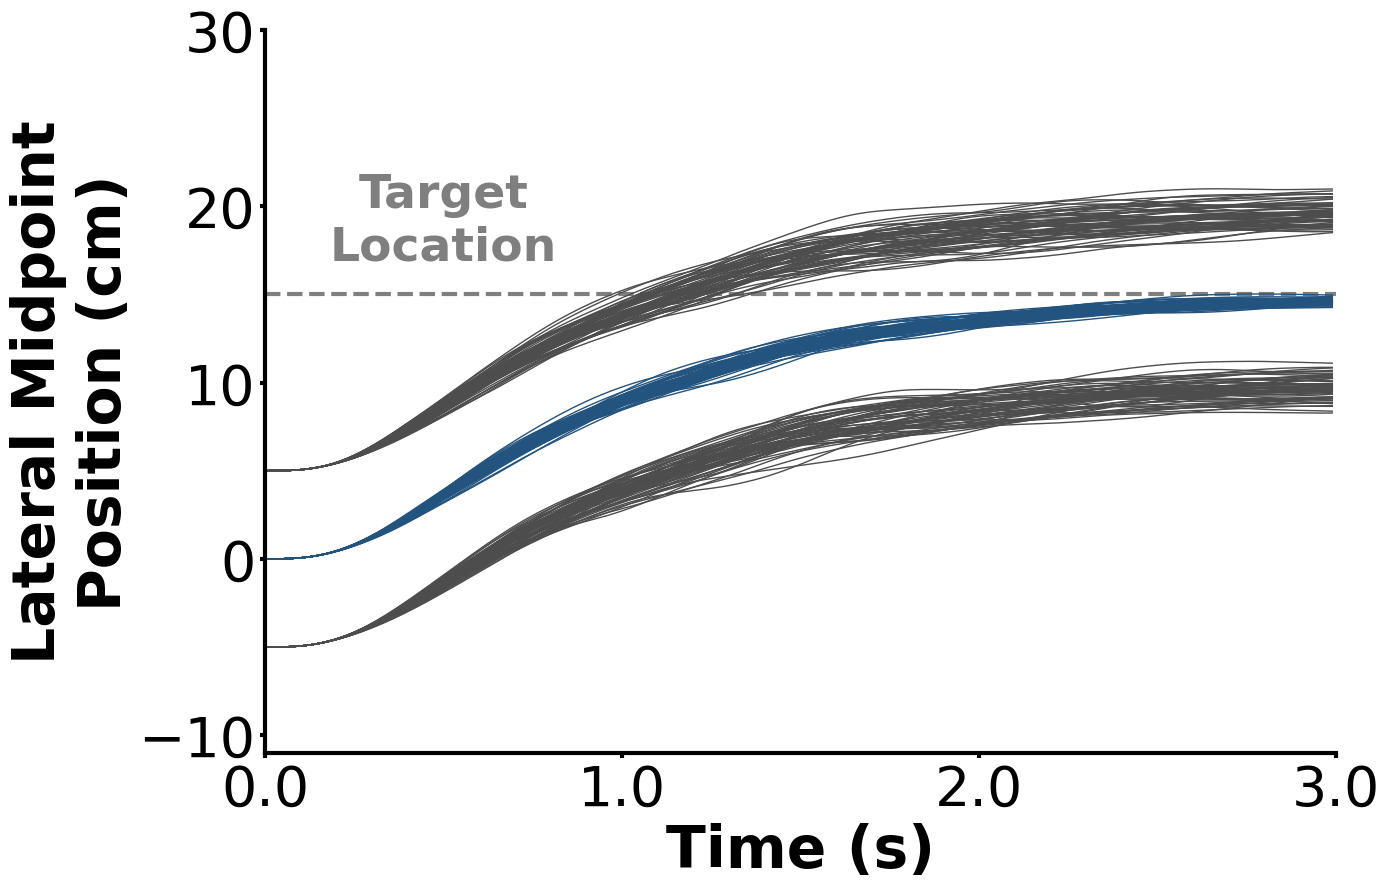

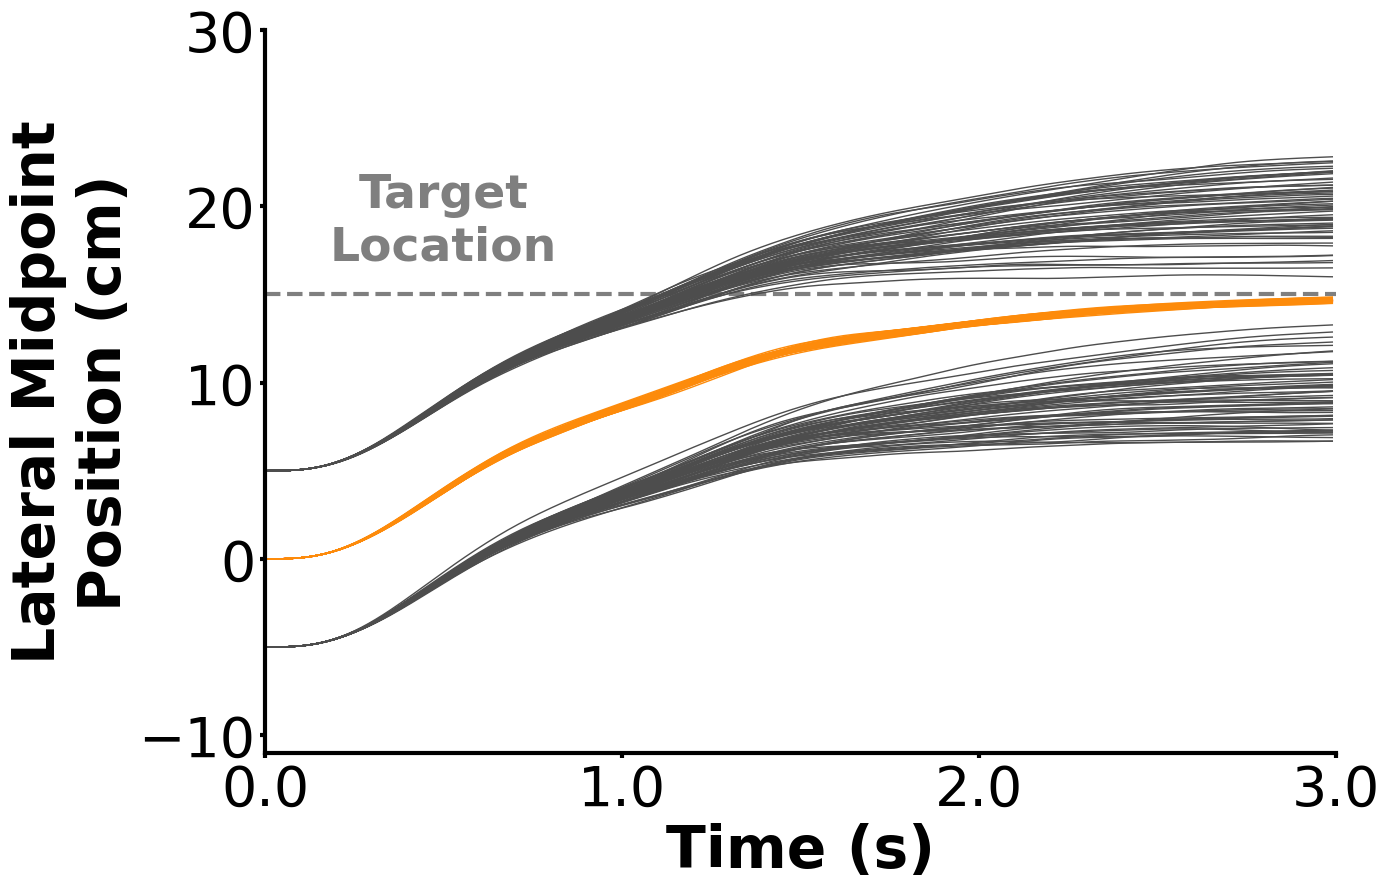

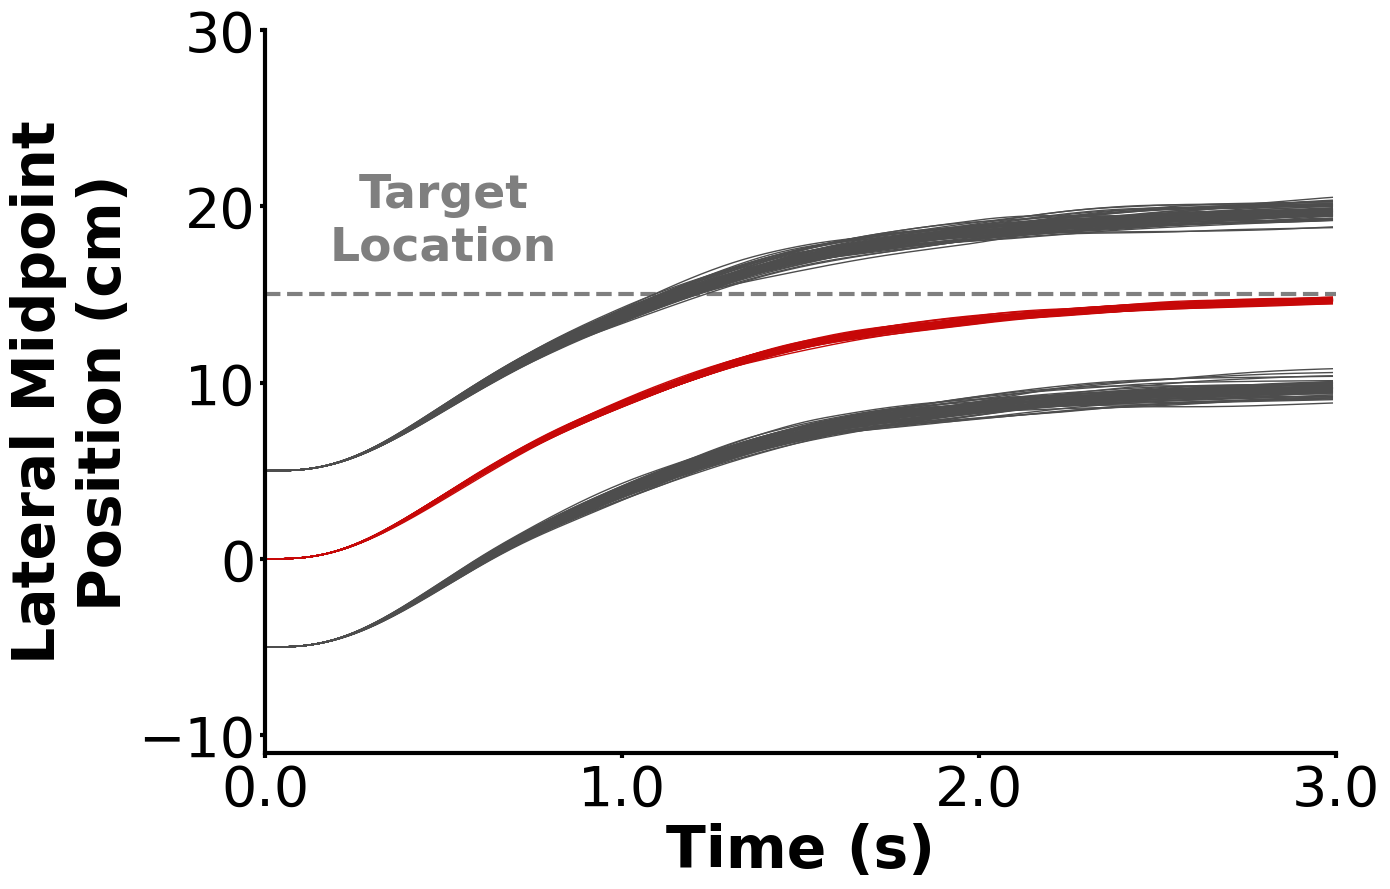

In [17]:
batch_no = 0
for condition_idx in range(3):
    yticks = np.arange(-10, 31, 10)
    text_annotations = [('Target\nLocation', [500, 17])]
    fig = plot_cursorhand_timetrajectories(X_batches_allN[batch_no], condition_idx=condition_idx, data_type='x', max_time_sample=300, yticks=yticks, text_annotations=text_annotations, params=plot_params)
    fig.savefig(plot_params.plots_directory + r'1D Task Sims\Kinematics\\' + f'2iLQR_{conditions[condition_idx]}_Nperturb_{plot_params.figure_theme_color}.png', transparent=True, dpi=600)

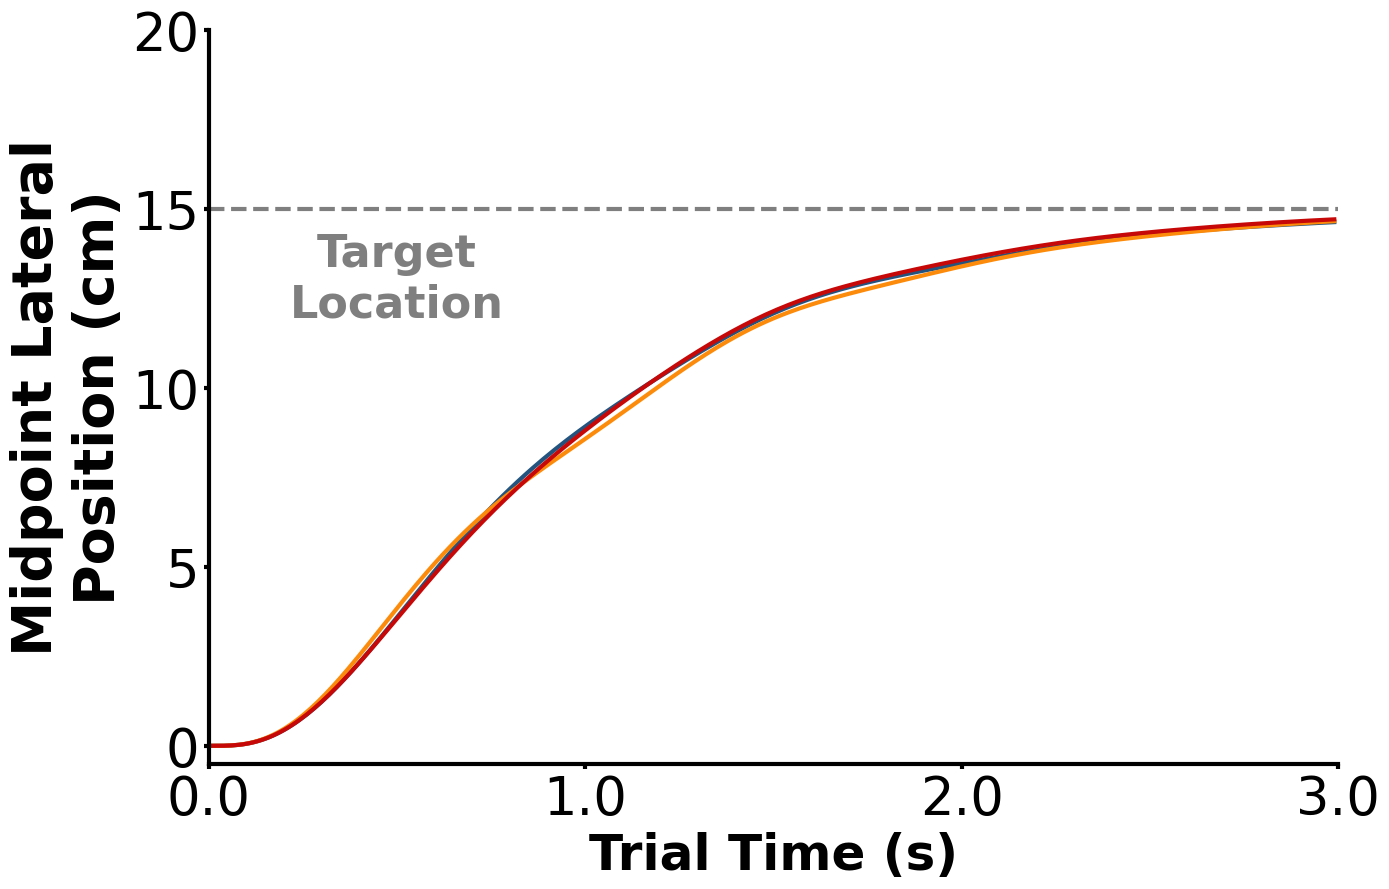

In [33]:
yticks = np.arange(0, 21, 5)
text_annotations = [('Target\nLocation', [500, 12])]
fig = plot_timetrajectories_meanbatches(X_batches_allN, data_type='x', max_time_sample=300, yticks=yticks, text_annotations=text_annotations, params=plot_params)
fig.savefig(model_params.plots_directory + r'1D Task Sims\Kinematics\\' + f'2iLQR_TimePlotX_Nperturb.png', transparent=True, dpi=600)

### Variability Analysis

#### Calculating variability using UCM

In [23]:
var_task_allN = np.zeros((BATCHES, len(conditions), model_params.N+1))
var_null_allN = np.zeros_like(var_task_allN)
for batch in range(BATCHES):
    # compute variabilities
    for ftype_idx, feedback_type in enumerate(conditions):
        var_task_allN[batch, ftype_idx, :], var_null_allN[batch, ftype_idx, :] = calculate_variabilities(X_batches_allN[batch][ftype_idx])

#### Plotting task-relevant and task-irrelevant variabilities for each batch

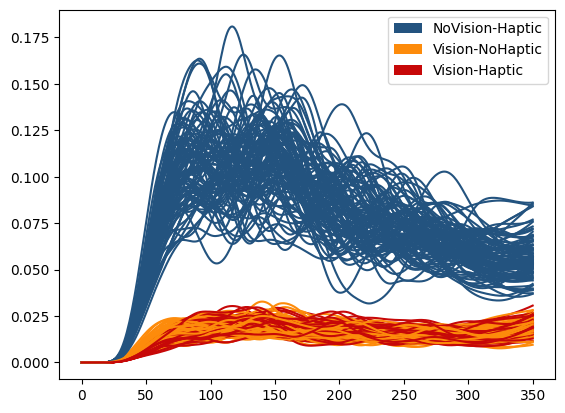

In [10]:
fig, ax = plt.subplots()
for batch in range(BATCHES):
    for idx, condition in enumerate(conditions):
        ax.plot(var_task_allN[batch, idx, :], color=plot_params.condition_colors[condition])

custom_legend = [Patch(facecolor=plot_params.condition_colors[condition], label=plot_params.condition_names[condition]) for condition in conditions]
ax.legend(handles=custom_legend)

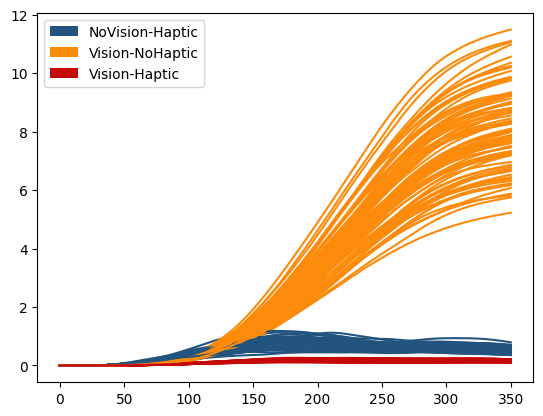

In [11]:
fig, ax = plt.subplots()
for batch in range(BATCHES):
    for idx, condition in enumerate(conditions):
        ax.plot(var_null_allN[batch, idx, :], color=plot_params.condition_colors[condition])

custom_legend = [Patch(facecolor=plot_params.condition_colors[condition], label=plot_params.condition_names[condition]) for condition in conditions]
ax.legend(handles=custom_legend)

#### Plotting mean variabilities across all batches

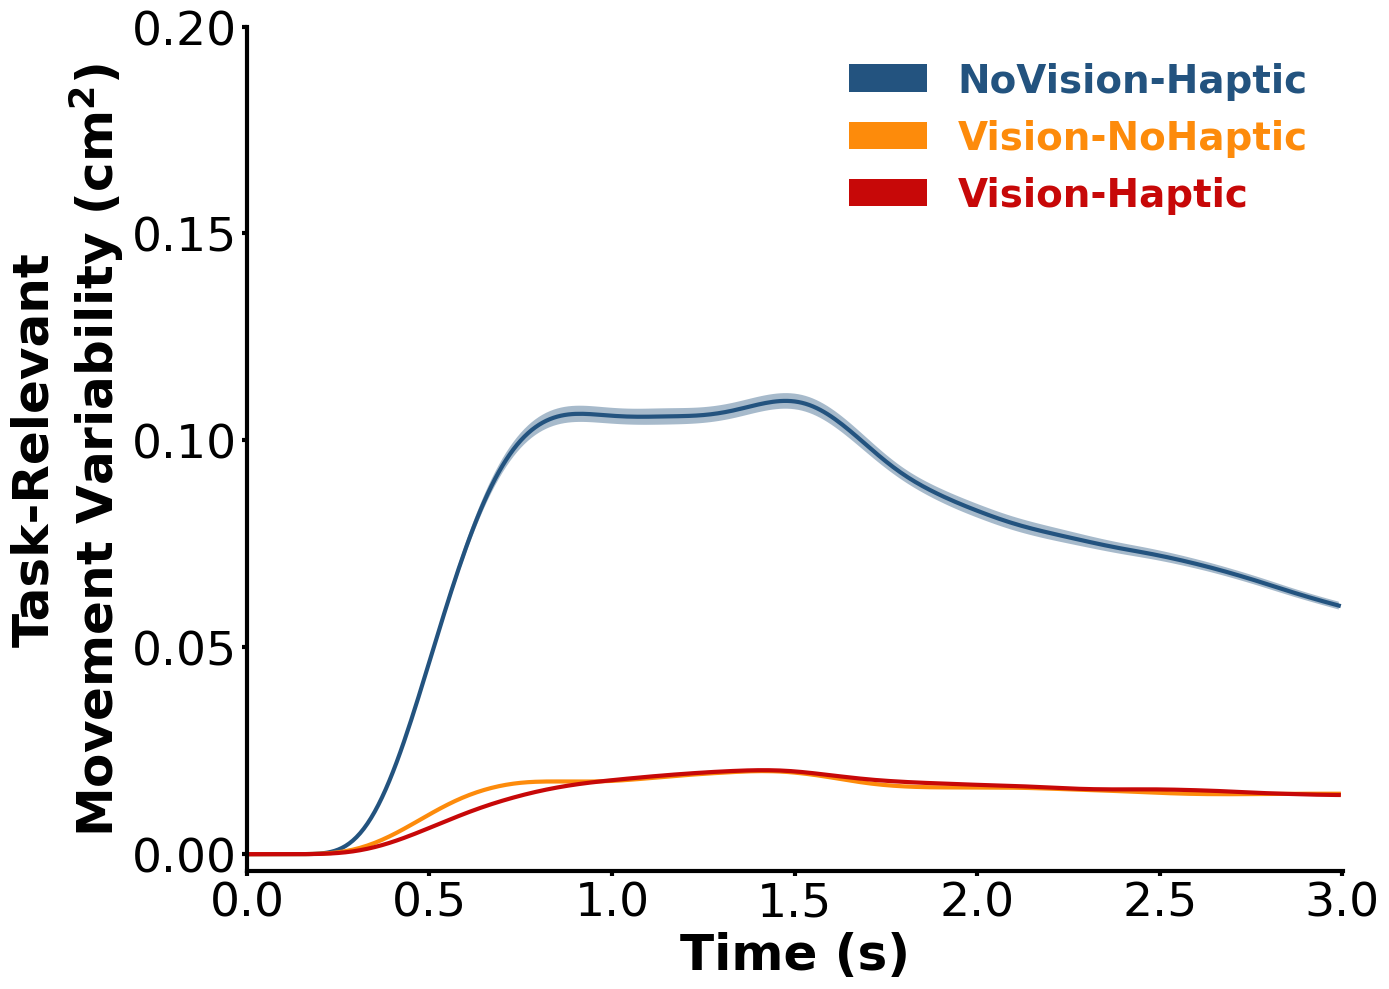

In [27]:
yticks = np.arange(0, 0.21, 0.05)
fig = plot_variabilities(var=var_task_allN, max_time_sample=300, var_type='Task', yticks=yticks, legend_loc='upper right', params=plot_params)
fig.savefig(plot_params.plots_directory + r'1D Task Sims\Variabilities\\' + f'2iLQR_Taskvar_TimePlot_Nperturb_{plot_params.figure_theme_color}.png', transparent=True, dpi=600)

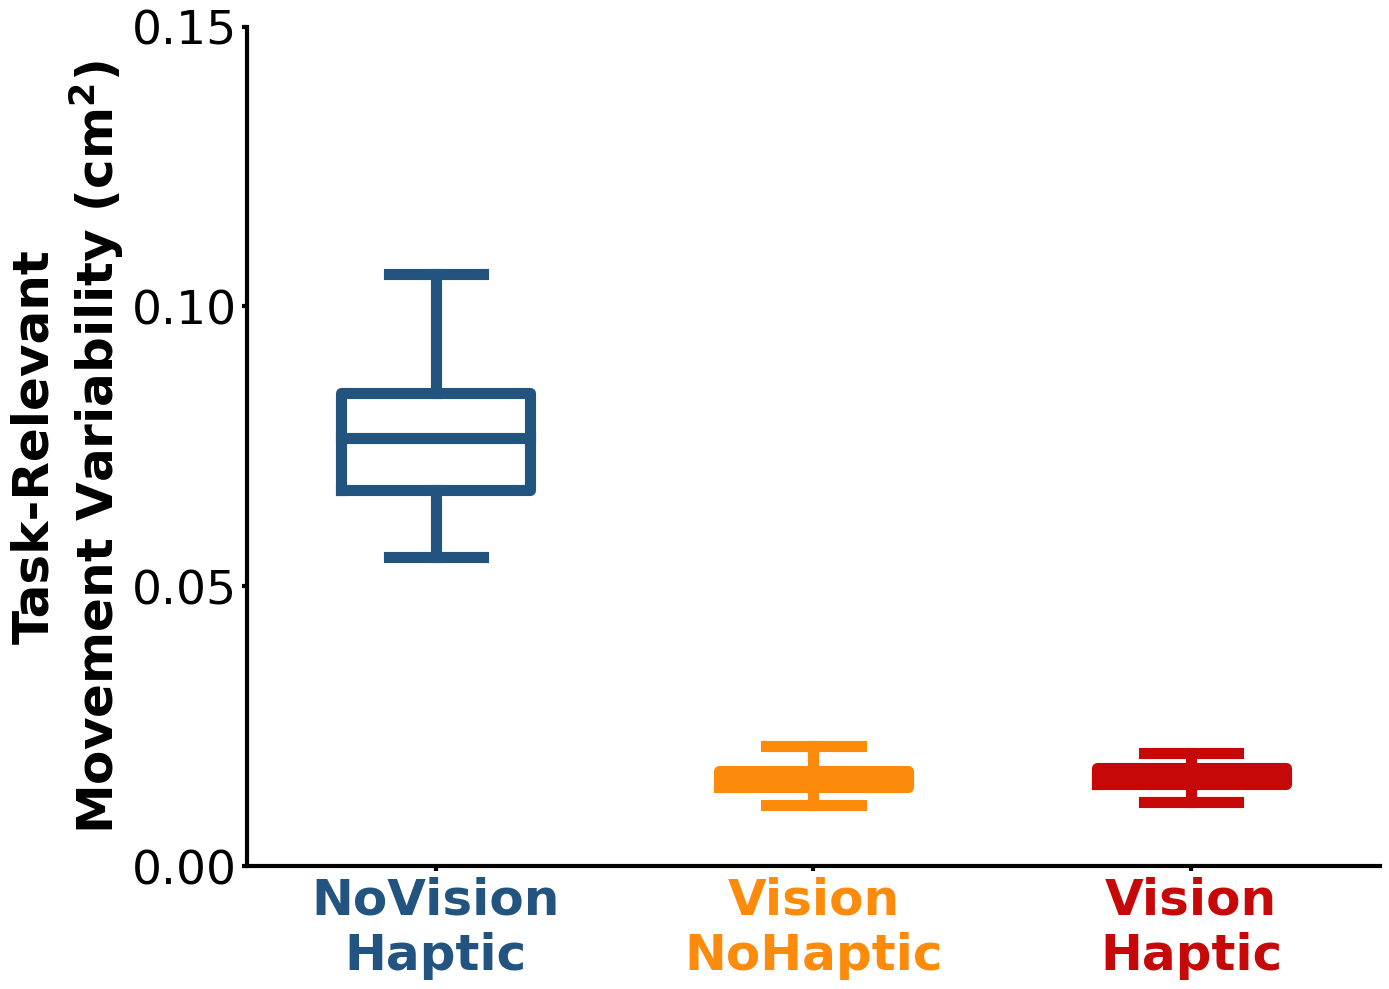

In [28]:
yticks_boxplot = np.arange(0.0, 0.16, 0.05)
fig = plot_variabilities_boxplot(var_data=var_task_allN, var_type='Task', step_window=[200, 250], yticks_boxplot=yticks_boxplot, params=plot_params)
fig.savefig(plot_params.plots_directory + r'1D Task Sims\Variabilities\\' + f'2iLQR_Taskvar_BoxPlot_Nperturb_{plot_params.figure_theme_color}.png', transparent=True, dpi=600)

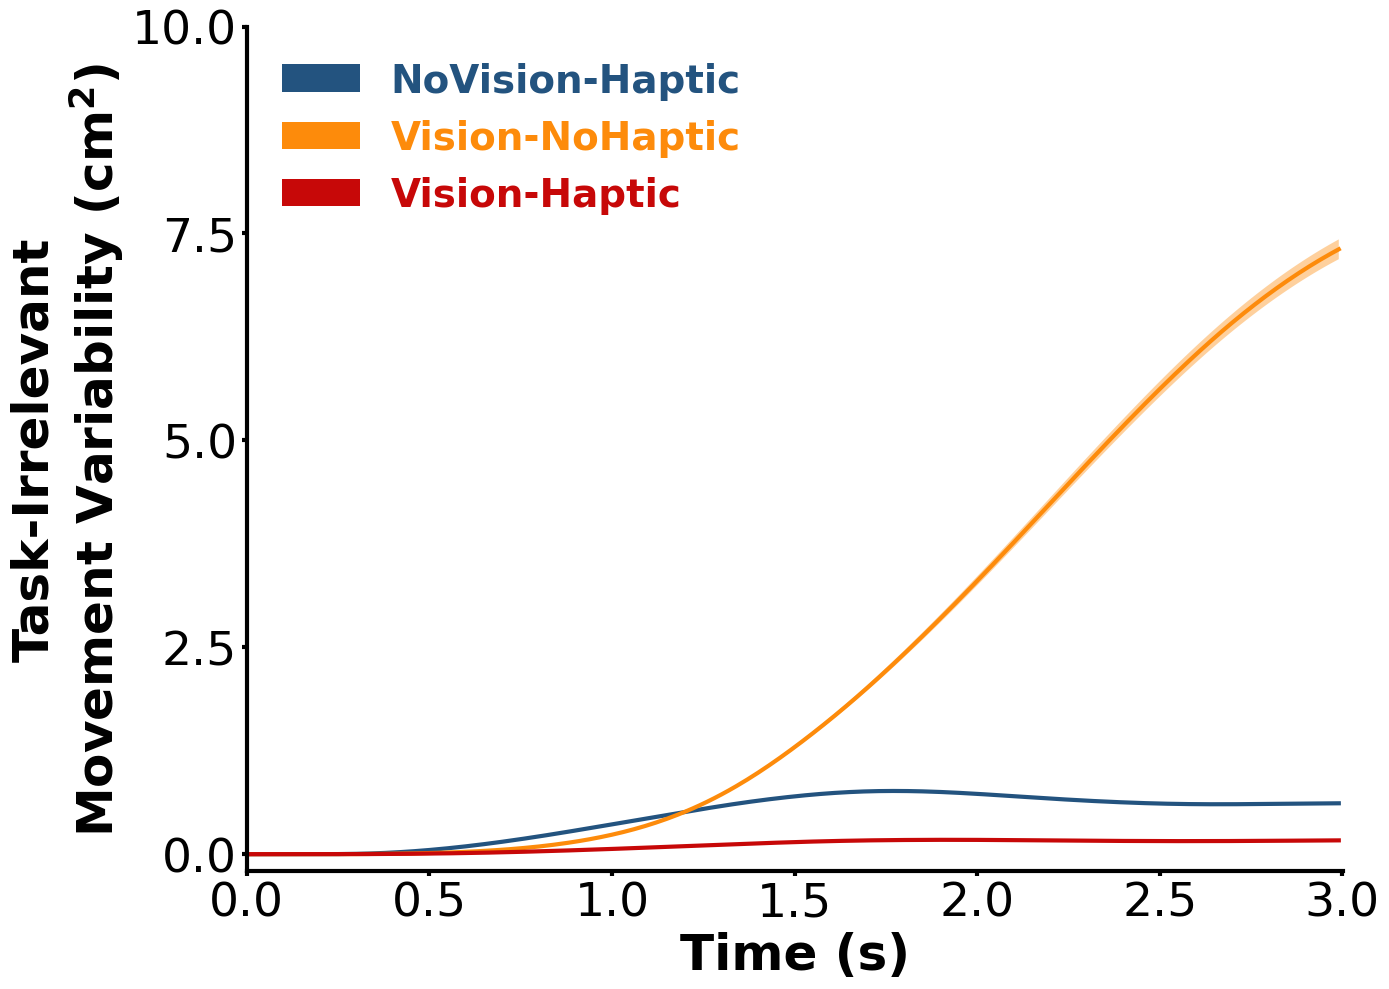

In [29]:
yticks = np.arange(0, 11, 2.5)
fig = plot_variabilities(var=var_null_allN, var_type='Null', max_time_sample=300, yticks=yticks, legend_loc='upper left', params=plot_params)
fig.savefig(plot_params.plots_directory + r'1D Task Sims\Variabilities\\' + f'2iLQR_Nullvar_TimePlot_Nperturb_{plot_params.figure_theme_color}.png', transparent=True, dpi=600)

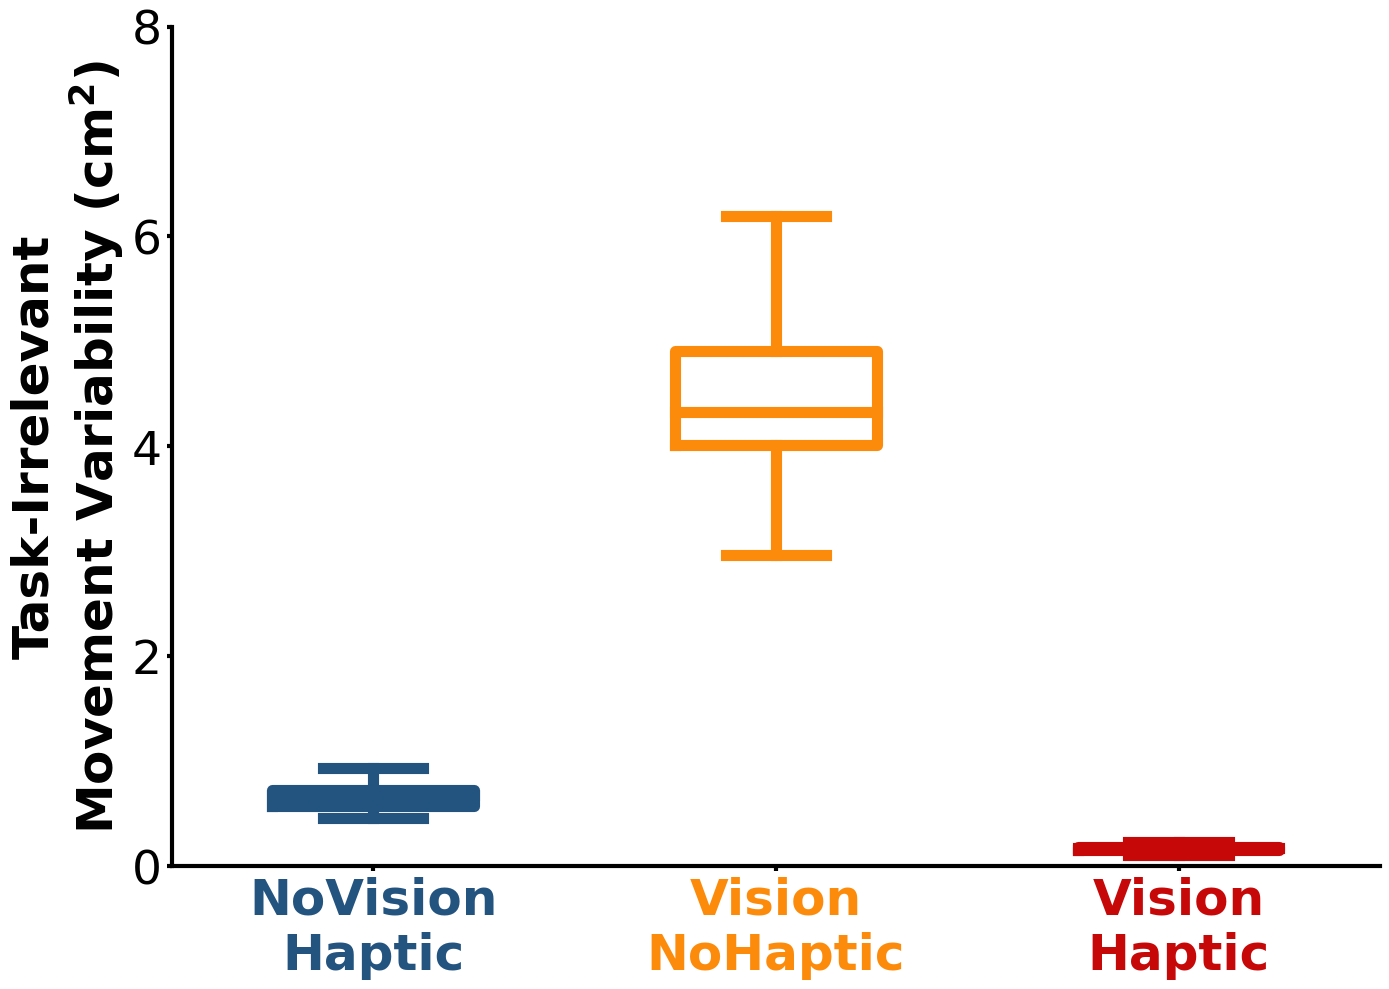

In [30]:
yticks_boxplot = np.arange(0, 9, 2)
fig = plot_variabilities_boxplot(var_data=var_null_allN, var_type='Null', step_window=[200, 250], yticks_boxplot=yticks_boxplot, params=plot_params)
fig.savefig(plot_params.plots_directory + r'1D Task Sims\Variabilities\\' + f'2iLQR_Nullvar_BoxPlot_Nperturb_{plot_params.figure_theme_color}.png', transparent=True, dpi=600)

## Midpoint movement smoothness analysis

#### Calculating log dimensionless jerk 

In [31]:
ldj_allN = np.zeros((BATCHES, len(conditions), RUNS))
for batch in range(BATCHES):
    for ftype_idx, feedback_type in enumerate(conditions):
        ldj_allN[batch, ftype_idx] = calculate_logdimjerk(X_batches_allN[batch][ftype_idx])

#### Plotting jerk summaries

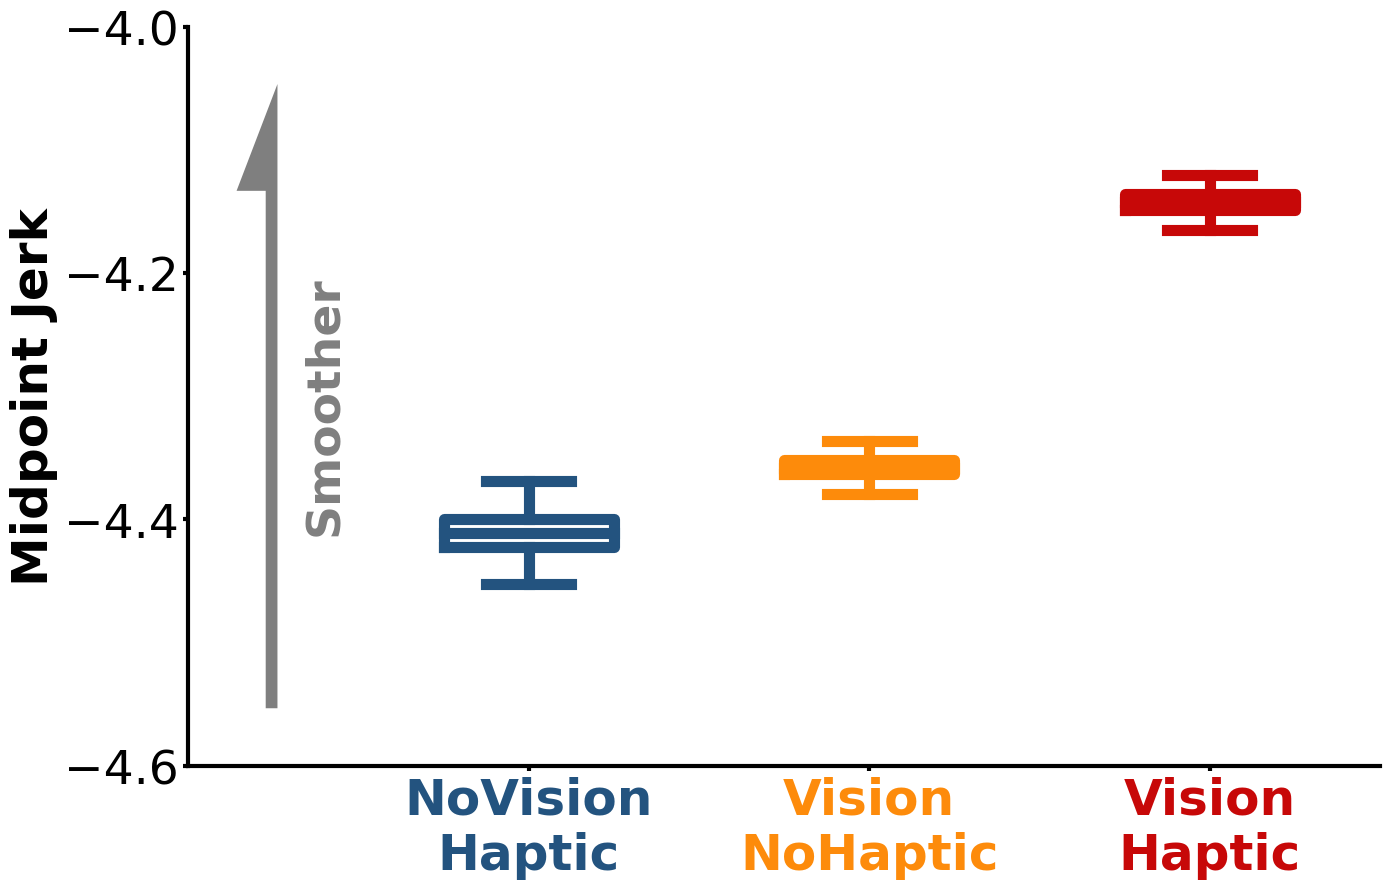

In [32]:
yticks = np.arange(-4.6, -3.9, 0.2)
arrow_props = {'x':-0.75, 'y':-4.55, 'dy':0.42, 'width':0.02, 'hlength':0.065, 'hwidth': 0.18}
fig = plot_logdimjerk_boxplot(ldj_allN, arrow_props=arrow_props, yticks_boxplot=yticks, params=plot_params)
fig.savefig(plot_params.plots_directory + r'1D Task Sims\Movement Smoothness\\' + f'2iLQR_Nperturb_{plot_params.figure_theme_color}.png', transparent=True, dpi=600)

### Save Data

In [27]:
importlib.reload(model_params)
save_variables = ['model_params', 'X_batches_allN']
save_name = 'NoPerturb_1.12.2023'
save_directory = model_params.data_save_directory + '\\1D Task Sims\\'
saveload_workspace.save_workspace(workspace=save_variables, globals=globals(), save_directory=save_directory,
                                   save_session_name=save_name)

X_batches_allN
